In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15476060973695832596
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17528611527058447927
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8591421255042219751
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31595870336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4878201874569329223
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"
]


In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization 
from tensorflow.keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam
# CuDNNLSTM error; The error was because from TensorFlow 2 you do not need to specify CuDNNLSTM. 
# You can just use LSTM with no activation function and it will automatically use the CuDNN version. You do have to install CuDNN first.

from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Using TensorFlow backend.


In [2]:
import pickle5 as pickle
with open( "/mnt/vdb/thesis/jax/AMPNonAMP.V4_sim95.reps", 'rb') as file:
    AMPs_df = pickle.load(file)

In [4]:
#AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df

,ID,length,class,reps
261,0_antitbpred|antitbpred,33,0,"[0.021885789930820465, 0.06677412241697311, 0...."
17,0_peptideDB.anti|peptideDB.anti,148,0,"[0.00609204825013876, -0.07883947342634201, 0...."
226,1000_pos_train_ds3|pos_train_ds3,86,0,"[0.012824639678001404, 0.0021224096417427063, ..."
302,10023_dbaasp|dbaasp_peptides,36,0,"[0.003721927758306265, -0.07121428847312927, -..."
60,"1003,1011,1019,1027,1035|CancerPPD_l_natural",20,0,"[0.02940366230905056, 0.001728760078549385, -0..."
...,...,...,...,...
456,tagenome__1003787_1003787.scaffolds.fasta_scaf...,47,0,"[0.019306708127260208, -0.030069835484027863, ..."
171,tagenome__1003787_1003787.scaffolds.fasta_scaf...,60,0,"[0.011303016915917397, -0.07055054605007172, 0..."
283,tagenome__1003787_1003787.scaffolds.fasta_scaf...,58,0,"[0.014870524406433105, -0.13572746515274048, 0..."
148,tagenome__1003787_1003787.scaffolds.fasta_scaf...,56,0,"[0.010077092796564102, -0.07801175117492676, 0..."


In [ ]:
# AMPs_df = pd.read_pickle('AMPsNonAMPs_df.plk')
AMPs_df = pd.read_pickle('AMPsNonAMPs_df.239.plk')
AMPs_df

### Utility function: plot_history, display_model_score

In [3]:
def plot_history(history):
  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Display model score(Loss & Accuracy) across all sets.
def display_model_score(model, train, val, test):
  train_score = model.evaluate(train[0], train[1], verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)
  val_score = model.evaluate(val[0], val[1], verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  test_score = model.evaluate(test[0], test[1], verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

def plot_history_CV(cv, estimator,x,y):
  # plot arrows
  fig1 = plt.figure(figsize=[12,12])
  ax1 = fig1.add_subplot(111,aspect = 'equal')
  ax1.add_patch(
      patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
      )
  ax1.add_patch(
      patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
      )

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0,1,100)
  i = 1
  for train,test in cv.split(x,y):
      model = create_Modelbaseline()
      model.fit(x[train],y.iloc[train],
            epochs=30,
            shuffle=True,verbose=0)
      prediction = model.predict(x[test])
      fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
      i= i+1

  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
  plt.show()

# Split Train/ Test / Validation set

In [6]:
X= np.array(AMPs_df['reps'].to_list())
y= np.array(AMPs_df['class'].to_list())

In [7]:
input_shape  = X.shape
input_shape

(88692, 1900)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.array(AMPs_df['reps'].to_list()), np.array(AMPs_df['class'].to_list()), test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [5]:
# Given data size
print('Train size: ', len(X_train))
print('Val size: ', len(X_val))
print('Test size: ', len(X_test))

Train size:  128565
Val size:  42855
Test size:  42856


# Model 1: Our simple model 

## Keras

In [19]:
def create_Modelbaseline():
  x_input = Input(shape=(1900,))
  layer_0 = Dense(896)(x_input)
  dropout_0 = Dropout(0.5)(layer_0)
  layer_1 = Dense(448)(dropout_0)
  dropout_1 = Dropout(0.5)(layer_1)
  layer_2 = Dense(224)(dropout_1)
  dropout_2 = Dropout(0.5)(layer_2)
  layer_3 = Dense(112)(dropout_2)
  dropout_3 = Dropout(0.5)(layer_3)
  layer_4 = Dense(56)(dropout_3)
  dropout_4 = Dropout(0.5)(layer_4)
  x_output = Dense(1, activation='sigmoid', name='output_layer')(dropout_4)

  model = Model(inputs=x_input, outputs=x_output)
  model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [20]:
 model = create_Modelbaseline()
 model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1900)]            0         
_________________________________________________________________
dense_5 (Dense)              (None, 896)               1703296   
_________________________________________________________________
dropout_5 (Dropout)          (None, 896)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 448)               401856    
_________________________________________________________________
dropout_6 (Dropout)          (None, 448)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 224)               100576    
_________________________________________________________________
dropout_7 (Dropout)          (None, 224)              

In [21]:
checkpoint = ModelCheckpoint("our_best_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                     callbacks=[checkpoint], verbose=2)


Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.86352, saving model to our_best_model.hdf5
1663/1663 - 5s - loss: 0.5031 - accuracy: 0.7806 - val_loss: 0.3301 - val_accuracy: 0.8635
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.86352 to 0.86983, saving model to our_best_model.hdf5
1663/1663 - 5s - loss: 0.3955 - accuracy: 0.8380 - val_loss: 0.3121 - val_accuracy: 0.8698
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.86983 to 0.87463, saving model to our_best_model.hdf5
1663/1663 - 5s - loss: 0.3660 - accuracy: 0.8536 - val_loss: 0.3128 - val_accuracy: 0.8746
Epoch 4/100

Epoch 00004: val_accuracy did not improve from 0.87463
1663/1663 - 5s - loss: 0.3466 - accuracy: 0.8622 - val_loss: 0.3408 - val_accuracy: 0.8508
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.87463 to 0.88049, saving model to our_best_model.hdf5
1663/1663 - 5s - loss: 0.3343 - accuracy: 0.8666 - val_loss: 0.2911 - val_accuracy: 0.8805
Epoch 6/100

Epoch 00006: val_accuracy did n

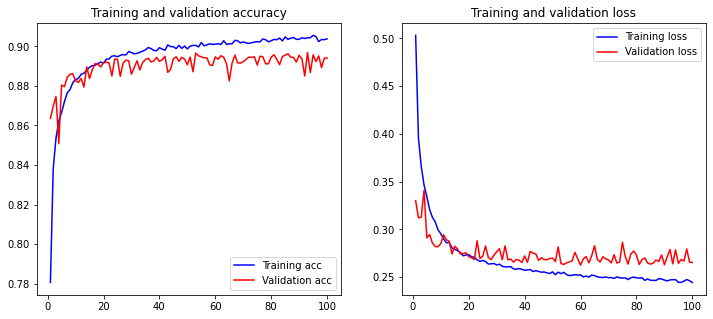

In [24]:
plot_history(history)

Overfitting if: training loss >> validation loss, training loss much greater than validation loss.

Underfitting if: training loss << validation loss, training loss much less than validation loss. 

In [25]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

1663/1663 [==============================] - 2s 1ms/step - loss: 0.2272 - accuracy: 0.9087
Train loss:  0.2272053211927414
Train accuracy:  0.9086894392967224
----------------------------------------------------------------------
555/555 [==============================] - 1s 1ms/step - loss: 0.2654 - accuracy: 0.8941
Val loss:  0.26535043120384216
Val accuracy:  0.8940752148628235
----------------------------------------------------------------------
555/555 [==============================] - 1s 1ms/step - loss: 0.2552 - accuracy: 0.9004
Test loss:  0.25519099831581116
Test accuracy:  0.9003889560699463


In [26]:
y_probas = model.predict(X_test)

In [27]:
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      8928
           1       0.90      0.90      0.90      8811

    accuracy                           0.90     17739
   macro avg       0.90      0.90      0.90     17739
weighted avg       0.90      0.90      0.90     17739



ROC area is 0.9004177329657576


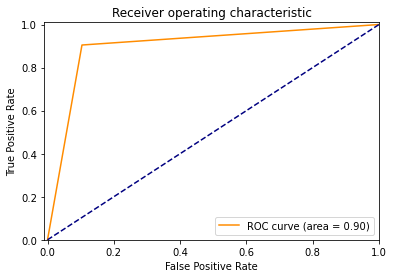

In [28]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
# probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_predict, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Cross validation with whole dataset

In [21]:

estimator = KerasClassifier(build_fn=create_Modelbaseline, epochs=100,verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)

In [22]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 89.40% (0.35%)


In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc', 'recall', 'precision','neg_log_loss']
scores = cross_validate(estimator, X, y, scoring=scoring, cv=kfold, return_train_score=True)
print("Accuracy TEST: %0.2f (+/- %0.2f) Accuracy TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2, scores['train_accuracy'].mean(), scores['train_accuracy'].std() * 2))
print("F1 TEST: %0.2f (+/- %0.2f) F1 TRAIN : %0.2f (+/- %0.2f) " %
      (scores['test_f1'].mean(), scores['test_f1'].std() * 2, scores['train_f1'].mean(), scores['train_f1'].std() * 2))
print("AUROC TEST: %0.2f (+/- %0.2f) AUROC TRAIN : %0.2f (+/- %0.2f)" %
      (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std() * 2, scores['train_roc_auc'].mean(), scores['train_roc_auc'].std() * 2))
print("recall TEST: %0.2f (+/- %0.2f) recall TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_recall'].mean(), scores['test_recall'].std() * 2, scores['train_recall'].mean(), scores['train_recall'].std() * 2))
print("Precision TEST: %0.2f (+/- %0.2f) Precision TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_precision'].mean(), scores['test_precision'].std() * 2, scores['train_precision'].mean(), scores['train_precision'].std() * 2))
print("Log loss TEST: %0.2f (+/- %0.2f) Log loss TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_neg_log_loss'].mean(), scores['test_neg_log_loss'].std() * 2, scores['train_neg_log_loss'].mean(), scores['train_neg_log_loss'].std() * 2))

# Model 2: Bidirectional LSTM
(The perforamnce did not good)

The below models are from https://towardsdatascience.com/protein-sequence-classification-99c80d0ad2df

https://stackoverflow.com/questions/38714959/understanding-keras-lstms

Embedding
* https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526

must specify 3 arguments:

    input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
    output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
    input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.


Input LSTM 
https://github.com/MohammadFneish7/Keras_LSTM_Diagram

(No batches , Timeesteps , no features)

In [6]:
import numpy as np
# https://stackoverflow.com/questions/52803989/how-to-correct-shape-of-keras-input-into-a-3d-array/52804200
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
print(X_val.shape)

(128565, 1900, 1)
(42856, 1900, 1)
(42855, 1900, 1)


In [12]:
x_input = Input( shape=(1900,1) )

Keras - ImportError: cannot import name 'CuDNNLSTM'

 To slove : for Tensorflow-2: You can just use LSTM with no activation function and it will automatically use the CuDNN version

* https://stackoverflow.com/questions/48086014/keras-model-with-cudnnlstm-layers-doesnt-work-on-production-server
* https://forums.developer.nvidia.com/t/importerror-cannot-import-name-cudnnlstm-from-tensorflow-keras-layers/82778
 

In [7]:
x_input = Input( shape=(1900,1) )

#initial conv
conv = Conv1D(256, 9,padding='same', activation = 'relu')(x_input) 

#conv = BatchNormalization()(conv)
x = MaxPooling1D(4)(conv)
x = Dropout(0.2)(x)


flat = Flatten()(x)

bi_rnn =  LSTM(64, return_sequences=True ) (x)
x = Dropout(0.2)(bi_rnn)
#x = Bidirectional( LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)
#                        , bias_regularizer=l2(0.01), return_sequences=False, stateful=False ) )(x)

flat = Flatten()(x)
layer_3 = Dense(1984, activation='relu')(flat)
dropout_3 = Dropout(0.2)(layer_3)
layer_3 = Dense(256, activation='relu')(layer_3)
# softmax classifier
x_output = Dense(1, activation='sigmoid', name='output_layer')(layer_3)

model_BLSTM = Model(inputs=x_input, outputs=x_output)
model_BLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_BLSTM.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1900, 256)         2560      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 475, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 475, 256)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 475, 64)           82176     
_________________________________________________________________
dropout_1 (Dropout)          (None, 475, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 30400)            

In [7]:
# Model III

x_input = Input( shape=(1900,1) )

#Conv1D
conv = Conv1D(64, kernel_size=40, strides=1, padding='same', activation='relu')(x_input)  # Extract whole motif pattern
conv = MaxPooling1D(pool_size=25)(conv)
conv = Conv1D(128, kernel_size=7, strides=1, padding='same', activation='relu')(conv)  # Extract extra features  
conv = MaxPooling1D(pool_size=4)(conv)

# batch normalization on features
#conv = BatchNormalization()(conv)

# Dropout and Dense Layer before LSTM
layer = Dense(1211, activation='relu')(conv)
dense_convinpn = Dropout(0.5)(layer)


# Bi-LSTM
lstm = Bidirectional(LSTM(64, return_sequences=True, name='bilstm'))(dense_convinpn) # learn order of sequence
drop_after_lstm = Dropout(0.5)(lstm)

# Dense out
output = Flatten()(drop_after_lstm)
x_output = Dense(1, activation='sigmoid')(output)

# comple
model_BLSTM = Model(inputs=x_input, outputs=x_output)
model_BLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_BLSTM.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1900, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1900, 64)          2624      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 76, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 128)           57472     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dense (Dense)                (None, 19, 1211)          156219    
_________________________________________________________________
dropout (Dropout)            (None, 19, 1211)         

In [8]:
#from keras import backend as K
#K.set_value(model_ProtCNN.optimizer.learning_rate, 0.00001)
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 80:
        lr = 0.1e-6
    elif epoch > 50:    
        lr = 0.3e-5
    elif epoch > 20:
        lr = 1e-4
        
    print(' Learning rate: ', lr)    
    return lr 

#learning rate decay
lr_scheduler = LearningRateScheduler(lr_schedule)

In [9]:
checkpoint_BLSTM = ModelCheckpoint("/mnt/vdb/thesis/best_model_BLSTM.4.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

history_BLSTM = model_BLSTM.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_val, y_val),
                     callbacks=[es,lr_scheduler], verbose=1)

 Learning rate:  0.001
Epoch 1/100
503/503 [==============================] - 56s 112ms/step - loss: 0.3579 - accuracy: 0.8315 - val_loss: 0.2554 - val_accuracy: 0.8955
 Learning rate:  0.001
Epoch 2/100
503/503 [==============================] - 56s 111ms/step - loss: 0.2504 - accuracy: 0.8998 - val_loss: 0.2411 - val_accuracy: 0.9030
 Learning rate:  0.001
Epoch 3/100
503/503 [==============================] - 55s 110ms/step - loss: 0.2283 - accuracy: 0.9100 - val_loss: 0.2212 - val_accuracy: 0.9150
 Learning rate:  0.001
Epoch 4/100
503/503 [==============================] - 56s 111ms/step - loss: 0.2098 - accuracy: 0.9185 - val_loss: 0.2033 - val_accuracy: 0.9217
 Learning rate:  0.001
Epoch 5/100
503/503 [==============================] - 56s 111ms/step - loss: 0.1999 - accuracy: 0.9227 - val_loss: 0.1997 - val_accuracy: 0.9216
 Learning rate:  0.001
Epoch 6/100
503/503 [==============================] - 55s 109ms/step - loss: 0.1932 - accuracy: 0.9252 - val_loss: 0.2162 - val_acc

In [13]:
model_BLSTM.save('/mnt/vdb/thesis/best_model_BLSTM.V4.h5') 

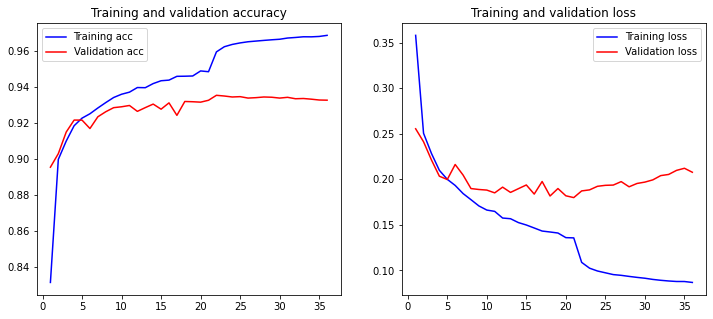

In [10]:
plot_history(history_BLSTM)

In [11]:
display_model_score(model_BLSTM,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

4018/4018 [==============================] - 46s 11ms/step - loss: 0.0804 - accuracy: 0.9717
Train loss:  0.0804130882024765
Train accuracy:  0.9716563820838928
----------------------------------------------------------------------
1340/1340 [==============================] - 15s 11ms/step - loss: 0.2077 - accuracy: 0.9327
Val loss:  0.2076585441827774
Val accuracy:  0.9327033162117004
----------------------------------------------------------------------
1340/1340 [==============================] - 15s 11ms/step - loss: 0.2121 - accuracy: 0.9314
Test loss:  0.21209943294525146
Test accuracy:  0.9314448237419128


In [22]:
y_probas

array([[[9.7694093e-01],
        [9.7690183e-01],
        [9.7948438e-01],
        ...,
        [9.8458117e-01],
        [9.8582262e-01],
        [9.8432964e-01]],

       [[9.5548019e-02],
        [1.1228124e-01],
        [1.0063087e-01],
        ...,
        [9.5385477e-02],
        [9.7495556e-02],
        [1.2400813e-01]],

       [[9.7842902e-01],
        [9.8039311e-01],
        [9.8057681e-01],
        ...,
        [9.8866218e-01],
        [9.8838621e-01],
        [9.7944438e-01]],

       ...,

       [[7.1135099e-04],
        [1.3960534e-03],
        [1.8303135e-03],
        ...,
        [2.8875249e-03],
        [2.3981279e-03],
        [2.0798075e-03]],

       [[9.9862504e-01],
        [9.9945158e-01],
        [9.9951577e-01],
        ...,
        [9.9980479e-01],
        [9.9961817e-01],
        [9.9969149e-01]],

       [[9.9397272e-01],
        [9.9669373e-01],
        [9.9685609e-01],
        ...,
        [9.9796665e-01],
        [9.9815065e-01],
        [9.9650097e-01]]

In [12]:
y_probas = model_BLSTM.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     21596
           1       0.93      0.93      0.93     21260

    accuracy                           0.93     42856
   macro avg       0.93      0.93      0.93     42856
weighted avg       0.93      0.93      0.93     42856



In [82]:
y = [ y_predict[i][0][0] for i in range(0,len(y_predict))]  
y_predict = np.asarray(y)

IndexError: invalid index to scalar variable.

In [83]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     21596
           1       0.93      0.93      0.93     21260

    accuracy                           0.93     42856
   macro avg       0.93      0.93      0.93     42856
weighted avg       0.93      0.93      0.93     42856



(42856, 19, 1)

# Conclusion